# Welcome to PAP-Lab!
A notebook to run the Peptide Abundance Predictor (PAP) on Google Colab.

If this was useful, please cite the [original paper describing the method](https://github.com/KULL-Centre/_2025_Voutsinos_degron_cytosol)

This notebook is a simple version of the main application. For additional functionality, for example automated saturation mutagenesis, please download the PAP script from [GitHub](https://github.com/KULL-Centre/_2025_Voutsinos_degron_cytosol) and run it locally

Note that the first cell needs to reseat the session so **do not use "run all"**

In [ ]:
#@title Install environment
#@markdown This cell needs to restart the session so do not use "run all" but execute cells individually and this only once

# download PAP code and parameters from github
! wget https://raw.githubusercontent.com/KULL-Centre/_2025_Voutsinos_degron_cytosol/refs/heads/main/models/PAP.py
! wget https://raw.githubusercontent.com/KULL-Centre/_2025_Voutsinos_degron_cytosol/refs/heads/main/models/pap_weights.tgz
! tar -zxf pap_weights.tgz

# downgrade to get keras 2, needs restart after install
! pip install tensorflow==2.14 numpy==1.26

# if "restart session" did not happen automatically, force it
import os
os.kill(os.getpid(), 9)



--2025-04-07 12:13:13--  https://raw.githubusercontent.com/KULL-Centre/_2025_Voutsinos_degron_cytosol/refs/heads/main/models/PAP.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41439 (40K) [text/plain]
Saving to: ‘PAP.py’

PAP.py              100%[===================>]  40.47K  --.-KB/s    in 0.01s   

2025-04-07 12:13:13 (3.50 MB/s) - ‘PAP.py’ saved [41439/41439]

--2025-04-07 12:13:13--  https://raw.githubusercontent.com/KULL-Centre/_2025_Voutsinos_degron_cytosol/refs/heads/main/models/pap_weights.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting res

In [58]:
from google.colab import files
import PAP
import re

#@title Input
#@markdown Protein sequence(s)
#@markdown - Input one amino acid sequence

name_input = 'Parkin' #@param {type:"string"}
sequence_input = 'MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKELRNDWTVQNCDLDQQSIVHIVQRPWRKGQEMNATGGDDPRNAAGGCEREPQSLTRVDLSSSVLPGDSVGLAVILHTDSRKDSPPAGSPAGRSIYNSFYVYCKGPCQRVQPGKLRVQCSTCRQATLTLTQGPSCWDDVLIPNRMSGECQSPHCPGTSAEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPEPDQRKVTCEGGNGLGCGFAFCRECKEAYHEGECSAVFEASGTTTQAYRVDERAAEQARWEAASKETIKKTTKPCPRCHVPVEKNGGCMHMKCPQPQCRLEWCWNCGCEWNRVCMGDHWFDV' #@param {type:"string"}

#@markdown - or upload a FASTA file (check box, click run, and a dialog box will appear below this cell. The field above will be ignored).

upload_fasta_file = False #@param {type:"boolean"}

#@title Settings
#@markdown Number of residues in each tile. Any number should work but the model has only been validated for 30 residues. However, we do have a feeling that, for example a peptide tag of 40 residues, may be best evaluated as a single tile of length 40 compared to the average of tiles of length 30.
tile_size = 30 #@param {type:"integer"}
#@markdown Apply the C-degron term to the last tile(s) of each sequence. If the sequence input is not that actual C-terminal, for example because a His-tag is added, this should be off.
apply_ct_term = True #@param {type:"boolean"}


seq_list = []

if upload_fasta_file:
  # Read file input
  uploaded = files.upload()
  for filename in uploaded.keys():
    # bug: if the same name.fa is uploaded, this will write name (1).fa
    # but not update filename variable so the old file will be loaded!
    print("Read %s" % (filename))
    for (seq_id,seq_aa) in PAP.read_fasta(filename):
      if len(seq_aa) < 30:
        print("WARNING: Sequence %s %s from file %s is shorter than 30 amino acids and ignored" %
              (seq_id,seq_aa,filename))
      else:
        seq_list.append((seq_id,seq_aa.upper()))
else:
  # Read text input
  if sequence_input != "":
    # remove non-word characters, i.e. whitespace, tab, newline, etc
    sequence = re.sub(r"\W", "", sequence_input).upper()
    if len(sequence) < tile_size:
      print("WARNING: Sequence '%s' is shorter than %d amino acid and ignored" %
            (sequence,tile_size))
    elif not PAP.is_aa_one_nat(sequence):
      print("WARNING: Sequence '%s' is not a canonical amino acid sequence and ignored" %
            (sequence))
    else:
      name = name_input.strip().split()[0]
      if name == "":
        name = "seq_input"
      seq_list.append((name, sequence))

if len(seq_list) < 1:
  print("No input")
else:
  print("Got %d sequences from input - in total %d residues" %
        (len(seq_list),sum([len(v[1]) for v in seq_list])))

  # check names
  seq_ids = [v[0] for v in seq_list]
  if len(seq_ids) != len(set(seq_ids)):
    print("WARNING: Sequence names used to identify tiles are not unique")

  # Tile sequences and calculate degron probability
  result = []
  for (seq_id,seq) in seq_list:
    tiles = PAP.tile_sequence(seq, tile_size, 1, seq_id=seq_id)
    (tile_degron_score,tile_ct_score) = PAP.calc_score(tiles, PAP.cnn2w1, include_ct=apply_ct_term)
    for (tile,score,ct_score) in zip(tiles,tile_degron_score,tile_ct_score):
      result.append([tile.parent_id, tile.seq, ct_score, score, tile.begin+1, tile.end,
                    tile.seq[tile.center_index], tile.begin+tile.center_index+1])

print("Compleated predictions of %d tile(s) from %d protein(s)" % (len(result),len(seq_list)))


Got 1 sequences from input - in total 465 residues
Compleated predictions of 465 tile(s) from 1 protein(s)


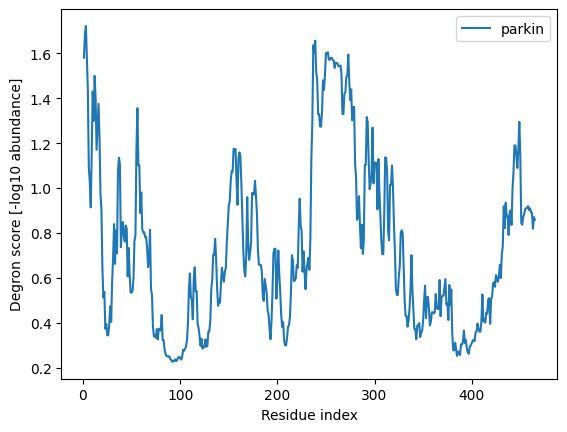

In [59]:
import matplotlib.pyplot as plt
import numpy as np

#@title Plot degron scores for a single protein
#@markdown Give the index (0-based) or name of a protein to plot

index_or_name = '0' #@param {type:"string"}

#@markdown Note that the shown scores are thought to be active when a peptide tile is exposed to the protein quality control aperatus of the cytosol, for example disordered regions of a protein. Scores above 1.4 are strong degrons and between 0.7 and 1.4 intermediate degrons.

seq_names = [v[0].lower() for v in result]
seq_names_uniq = np.unique(seq_names)
name2plot = None

input_is_int = None
try:
  plot_index = int(index_or_name)
except:
  input_is_int = False
else:
  input_is_int = True

if input_is_int:
  if plot_index >= len(seq_names_uniq):
    raise ValueError("No index %d, max is %d" % (plot_index,len(seq_names_uniq)-1))
  name2plot = seq_names_uniq[plot_index]
else:
  if index_or_name.lower() in seq_names_uniq:
    name2plot = index_or_name.lower()
  else:
    raise ValueError("No sequence named \'%s\'" % (index_or_name))

plot_index = np.where(np.array(seq_names) == name2plot)[0]
result_np = np.array(result)
resi = [int(v[7]) for v in result_np[plot_index] ]
if (len(resi) != len(set(resi))):
  print("WARNING: More points for same residue index - are sequence names unique?")
deg_prob = [float(v[3]) for v in result_np[plot_index] ]
plt.plot(resi, -np.log10(deg_prob), label=name2plot)
plt.plot()

plt.xlabel("Residue index")
plt.ylabel("Degron score [-log10 abundance]")
# plt.title("Line Graph Example")
plt.legend()
plt.show()


In [60]:
#@title Download all results
#@markdown If this fails, try the Google Chrome browser
filename = 'pap.txt' #@param {type:"string"}
write_header = True #@param {type:"boolean"}

if len(result) > 0:
  with open(filename, 'w') as f:
    if write_header:
      # white space separated text
      f.write("%-20s  %30s  %8s  %8s %5s  %4s  %4s  %4s\n" %
              ("name","sequence","score_ct","score","first","last","aa","resi"))

      # ecxel style csv
      # f.write("name;sequence;deg_prob;aa;resi")
    for line in result:
      # white space separated text
      f.write("%-20s  %30s  %8.5f  %8.5f  %4d  %4d  %4s  %4d\n" % tuple(line))

      # quoted strings
      # f.write("%-20s  %17s  %8.5f  %2s  %4d\n" %
      #        ("\""+line[0]+"\"", "\""+line[1]+"\"", line[2], "\""+line[3]+"\"", line[4]))

      # ecxel style csv
      # f.write("%s;%s;%.5f;%s;%d\n" % tuple(line))
  files.download(filename)
else:
  print("No result to download")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>